In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve

warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [3]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}

dic1 = {'Yes':1,'No':0}

dic2 = {'In State':1,'Out of State':0}

dic3 = {'Owner':1,'1st Gen':0}

dic4 = {'Couple':1,'Single':0}

dic5 = {'Weekday':0, 'Weekend':1}


# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)

df['Homeowner']=df['Homeowner'].replace(dic1)

df['InState']=df['InState'].replace(dic2)

df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)

df['relationStatus']=df['relationStatus'].replace(dic4)

df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15761 entries, 146456 to 384973
Data columns (total 15 columns):
?TourContractGeneration       15761 non-null int64
?TourGeneration               15761 non-null int64
Age                           15761 non-null int64
AgentLine                     15761 non-null object
BookingWindow                 15761 non-null object
FirstGenVsOwner               15761 non-null int64
HHIncomeRanges                15761 non-null object
Homeowner                     15761 non-null int64
InState                       15761 non-null int64
Programs (Budget)             15761 non-null object
relationStatus                15761 non-null int64
ResultOfTour                  15761 non-null int64
TourSeason                    15761 non-null object
WeekdayOrWeekend              15761 non-null int64
NetVolumePlusNonGoodVolume    15761 non-null float64
dtypes: float64(1), int64(9), object(5)
memory usage: 1.9+ MB
None


In [4]:
dfX = df.drop(['ResultOfTour',  'AgentLine', 'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=['BookingWindow',
       'HHIncomeRanges', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])     


scaler2 = StandardScaler()
scaler2.fit(dfX[['?TourContractGeneration']])
dfX['?TourContractGeneration'] = scaler2.transform(dfX[['?TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])


X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)

dfX1 = X_train
dfY1 = y_train
 
print(dfX1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12608 entries, 352236 to 359126
Data columns (total 38 columns):
?TourContractGeneration                        12608 non-null float64
?TourGeneration                                12608 non-null float64
Age                                            12608 non-null float64
FirstGenVsOwner                                12608 non-null int64
Homeowner                                      12608 non-null int64
InState                                        12608 non-null int64
relationStatus                                 12608 non-null int64
WeekdayOrWeekend                               12608 non-null int64
BookingWindow_Inside 2 Days                    12608 non-null uint8
BookingWindow_Inside 90 days                   12608 non-null uint8
BookingWindow_Inside Half Year                 12608 non-null uint8
BookingWindow_Inside Month                     12608 non-null uint8
BookingWindow_Inside Week                      12608 non-null u

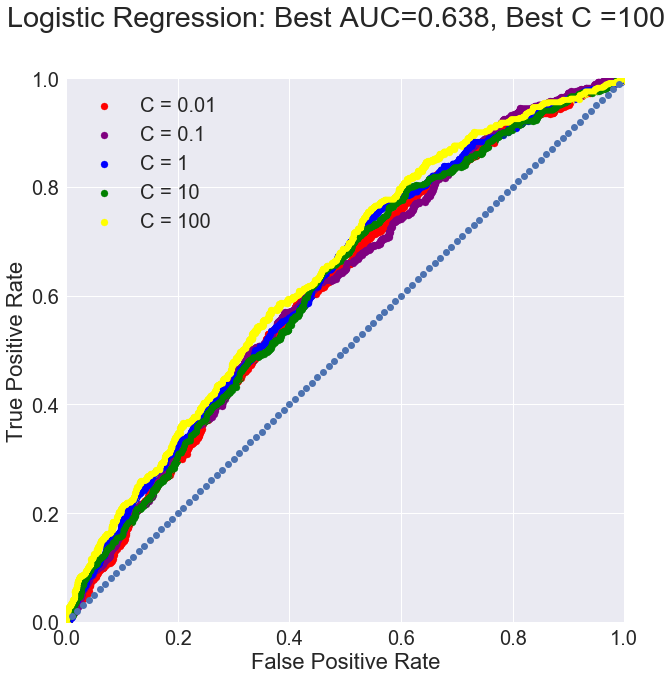

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.utils import class_weight


bestC = 0
bestAUCC = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,100]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')



weight = {0:0.15,1:0.85}
#weight = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(dfY1), dfY1)))

for train, test in kf.split(dfX1,dfY1):
    lr = LogisticRegression(C=Cs[i],class_weight = weight)
    lr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCC:
        bestC=Cs[i]
        bestAUCC=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='C = '+str(Cs[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('Logistic Regression: Best AUC='+str(round(bestAUCC,3))+', Best C ='+str(bestC))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

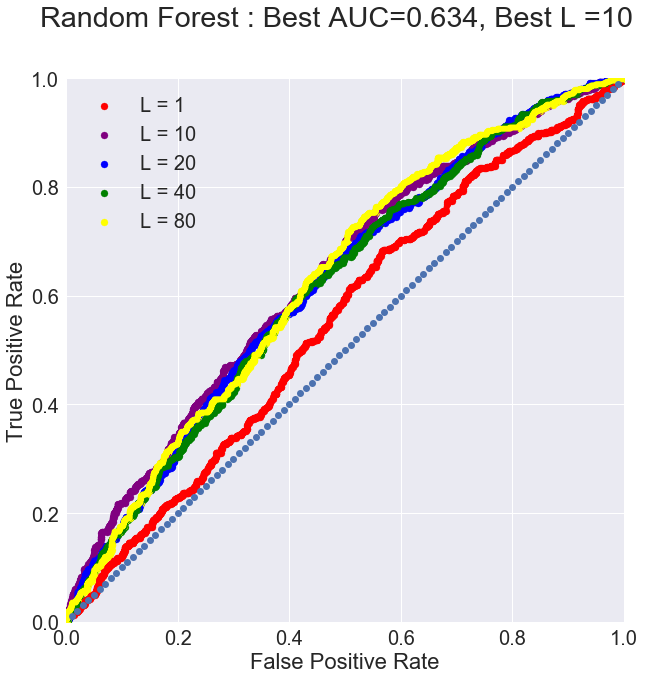

In [6]:
from sklearn.ensemble import RandomForestClassifier

bestL = 0
bestAUCL = 0
bestFeatureImportances= []
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ls = [1,10,20,40,80]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    rfr = RandomForestClassifier(n_estimators=1000,min_samples_leaf=Ls[i], random_state=42,class_weight = weight)
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCL:
        bestL=Ls[i]
        bestAUCL=auc
        bestFeatureImportances = rfr.feature_importances_
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='L = '+str(Ls[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('Random Forest : Best AUC='+str(round(bestAUCL,3))+', Best L ='+str(bestL))
plt.plot(x,y,'o')
plt.show()

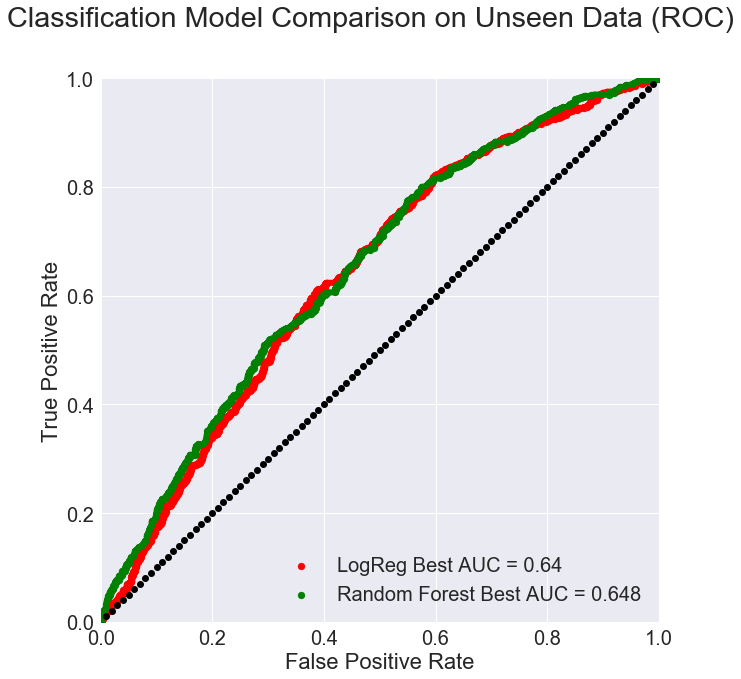

In [7]:
#logistic regregression best model 
lr = LogisticRegression(C=bestC,class_weight = {0:1,1:5})
lr.fit(dfX1,dfY1)
preds = lr.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=fpr, y=tpr, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Red',linewidth=6.0)

#random forest best model 
rf = RandomForestClassifier(n_estimators=1000,min_samples_leaf =bestL,random_state=42,class_weight = {0:1,1:5})
rf.fit(dfX1,dfY1)
preds = rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Green',linewidth=6.0)


plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot(x,y,'o', color='Black')
plt.suptitle('Classification Model Comparison on Unseen Data (ROC)')
plt.show()

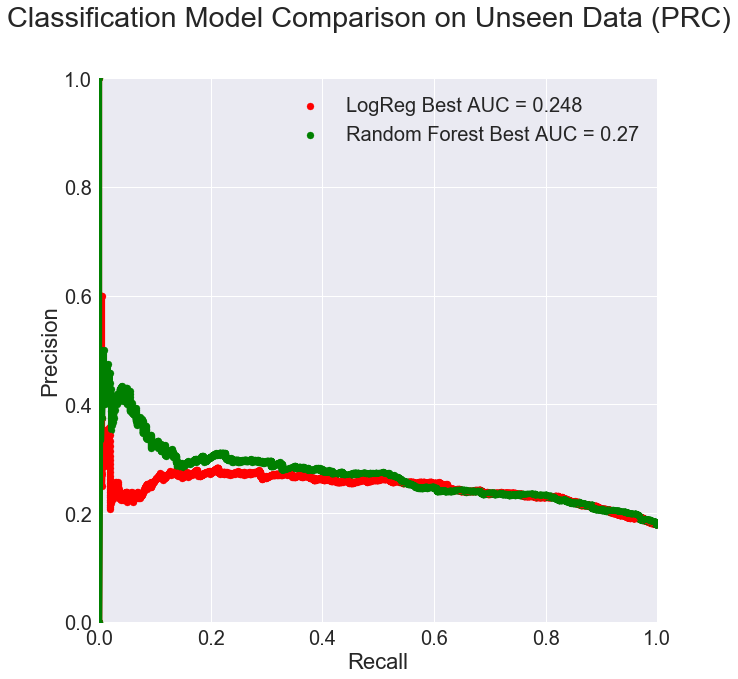

In [8]:
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#logistic regregression best model 
lr = LogisticRegression(C=bestC,class_weight = {0:1,1:5})
lr.fit(dfX1,dfY1)
preds = lr.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=r, y=p, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Red',linewidth=6.0)



#random forest best model 
rf = RandomForestClassifier(n_estimators=1000,min_samples_leaf =bestL,random_state=42,class_weight = {0:1,1:5})
rf.fit(dfX1,dfY1)
preds = rf.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Green',linewidth=6.0)

x_mis = X_test[y_test !=rf.predict(X_test)]
x_mis['prediction'] = rf.predict(x_mis)
x_mis['actual'] = y_test[y_test != rf.predict(X_test)]

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.suptitle('Classification Model Comparison on Unseen Data (PRC)')
plt.show()

In [9]:
for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(round(x,3),y)

0.208 Age
0.116 ?TourGeneration
0.075 ?TourContractGeneration
0.055 InState
0.032 WeekdayOrWeekend
0.031 TourSeason_Winter
0.027 HHIncomeRanges_90k to 149k
0.026 TourSeason_Spring
0.025 HHIncomeRanges_70k to 89k
0.024 FirstGenVsOwner
0.024 BookingWindow_Inside 90 days
0.021 TourSeason_Summer
0.021 Programs (Budget)_(09) GL7 Inhouse
0.021 HHIncomeRanges_150k to 199k
0.021 Programs (Budget)_(12) Outbound Telemarktng
0.02 BookingWindow_Inside Month
0.019 TourSeason_Fall
0.018 BookingWindow_Inside 2 Days
0.017 BookingWindow_Inside Week
0.017 HHIncomeRanges_200k to 349k
0.016 Programs (Budget)_(21) GTL In House
0.016 BookingWindow_Inside Half Year
0.015 relationStatus
0.015 BookingWindow_Inside Year
0.014 Programs (Budget)_(06) GC8 Inhouse
0.012 HHIncomeRanges_Under 70k
0.012 Programs (Budget)_(17) Guest Member
0.01 Programs (Budget)_(14) Summit County OPC
0.009 BookingWindow_Over a Year
0.009 HHIncomeRanges_350k to 500k
0.008 Programs (Budget)_(15) Internet
0.008 Programs (Budget)_(24) Fro

In [10]:
#remove standarization to see actual misclassified values

x_mis['Age'] = scaler1.inverse_transform(x_mis[['Age']])

x_mis['?TourContractGeneration'] = scaler2.inverse_transform(x_mis[['?TourContractGeneration']])

x_mis['?TourGeneration'] = scaler3.inverse_transform(x_mis[['?TourGeneration']])


# remove binarization of categorical data
x_mis['actual']=x_mis['actual'].replace({v: k for k, v in dic.items()})

x_mis['Homeowner']=x_mis['Homeowner'].replace({v: k for k, v in dic1.items()})

x_mis['InState']=x_mis['InState'].replace({v: k for k, v in dic2.items()})

x_mis['FirstGenVsOwner']=x_mis['FirstGenVsOwner'].replace({v: k for k, v in dic3.items()})

x_mis['relationStatus']=x_mis['relationStatus'].replace({v: k for k, v in dic4.items()})

x_mis['WeekdayOrWeekend']=x_mis['WeekdayOrWeekend'].replace({v: k for k, v in dic5.items()})

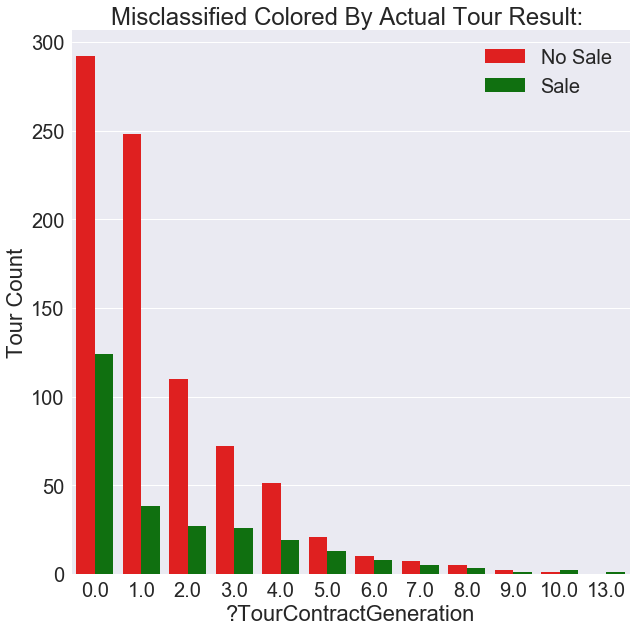

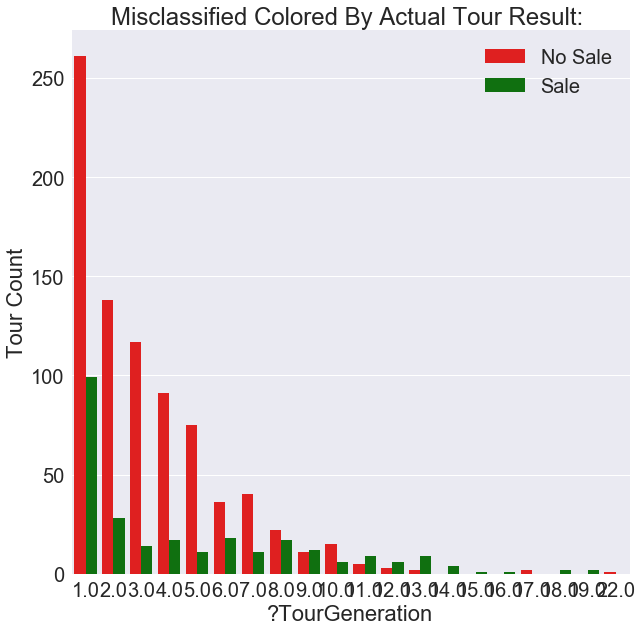

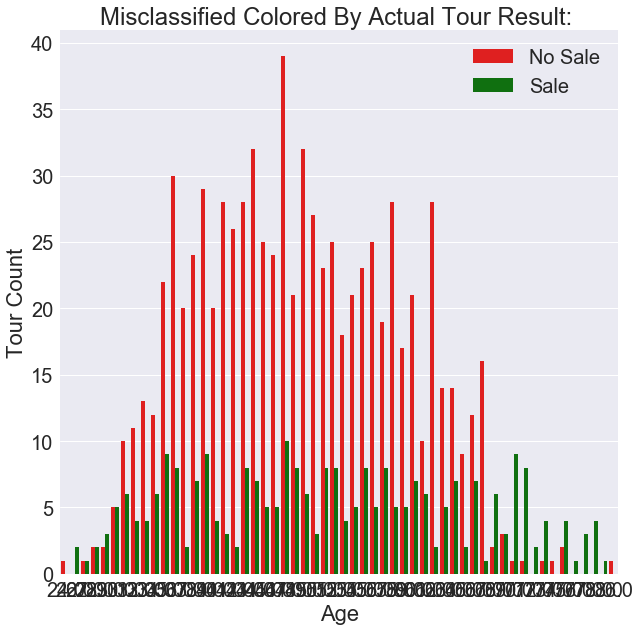

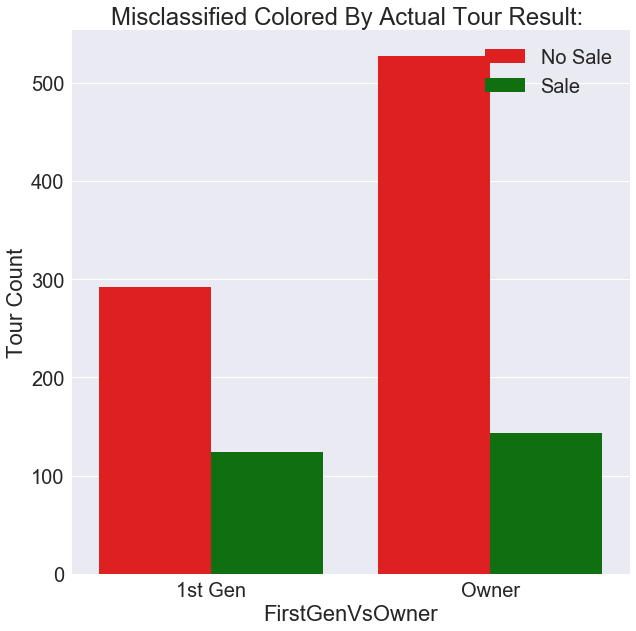

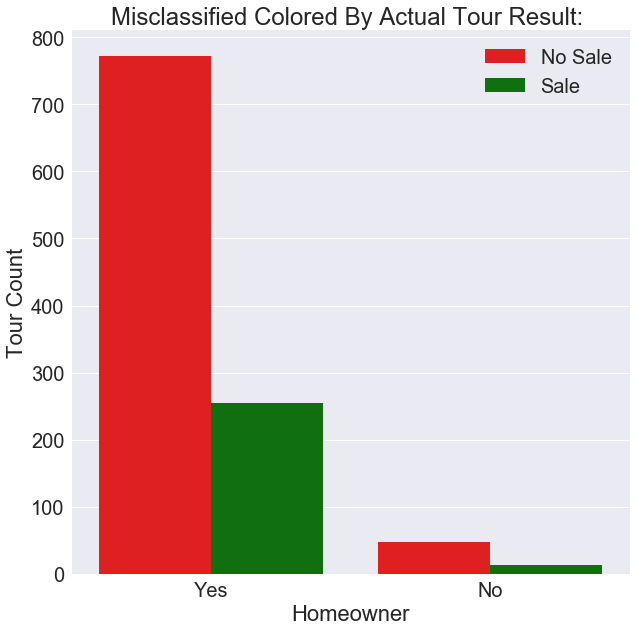

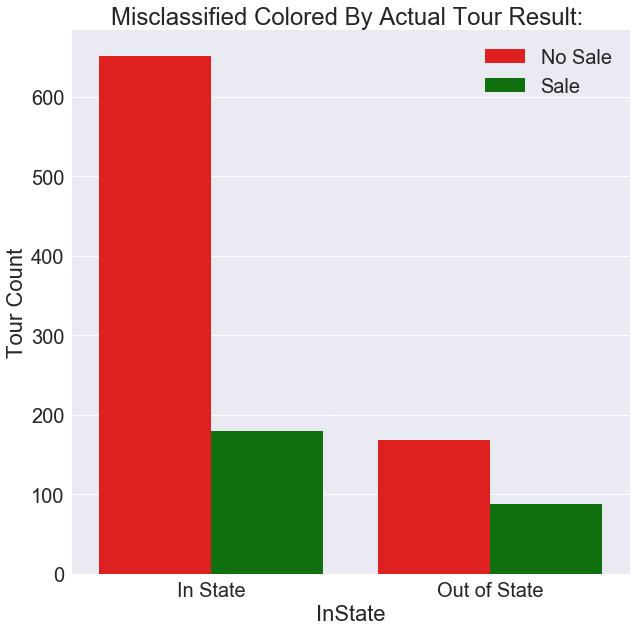

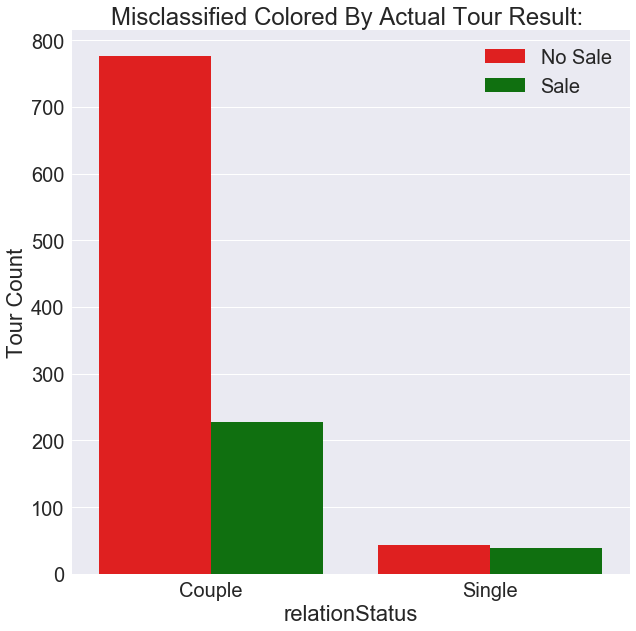

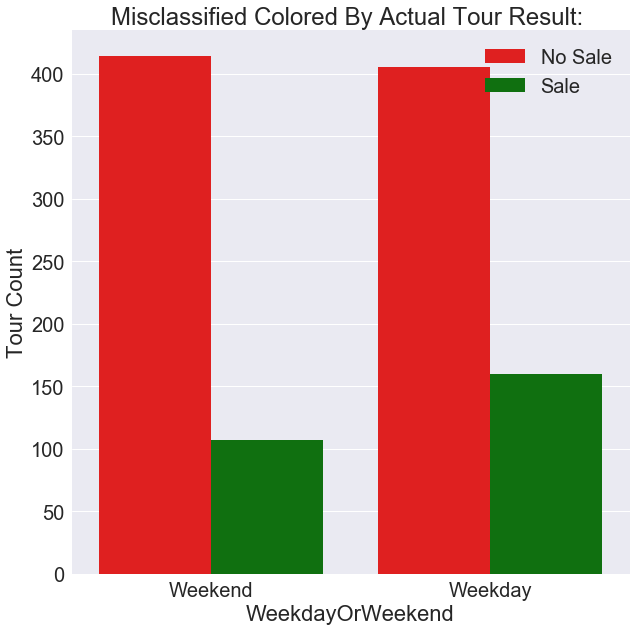

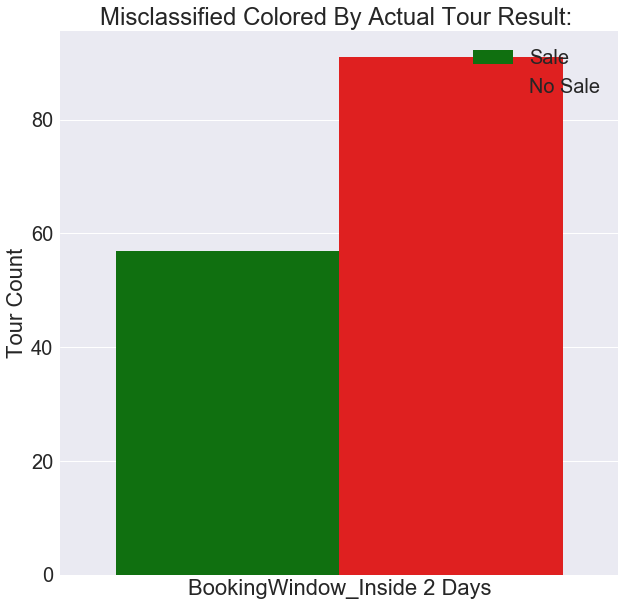

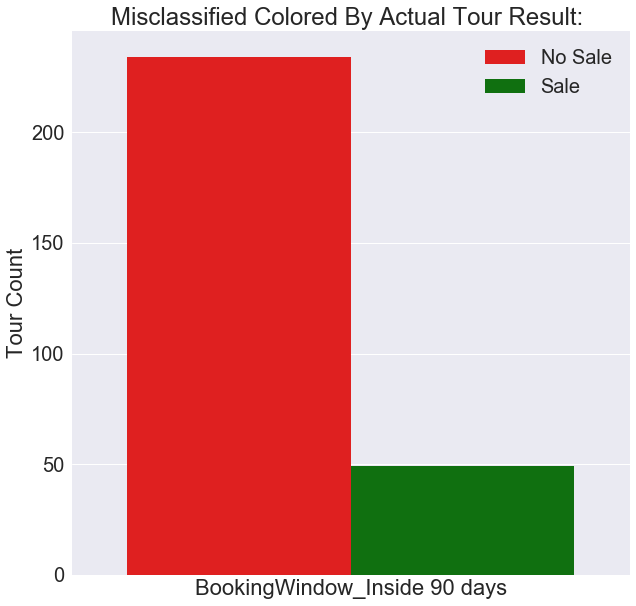

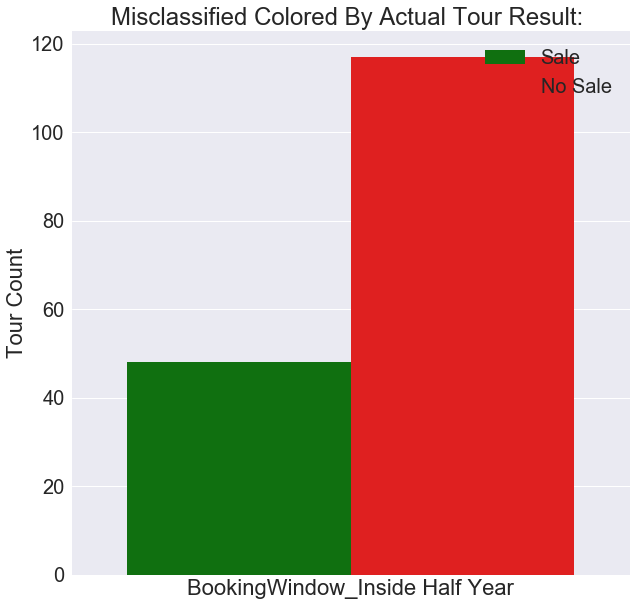

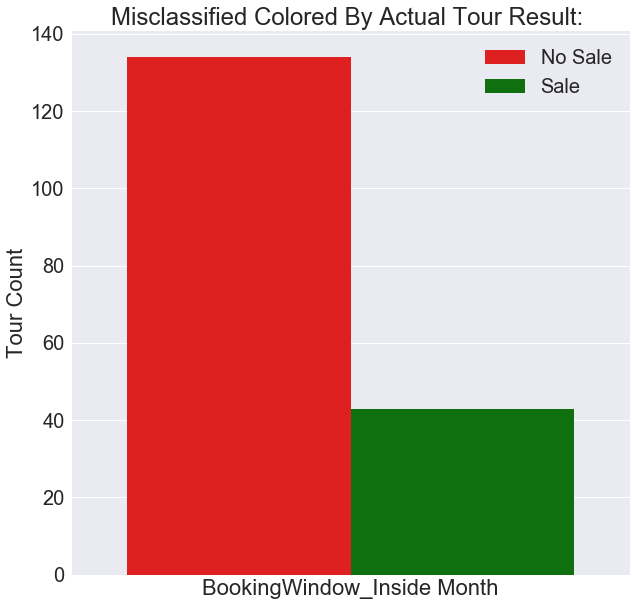

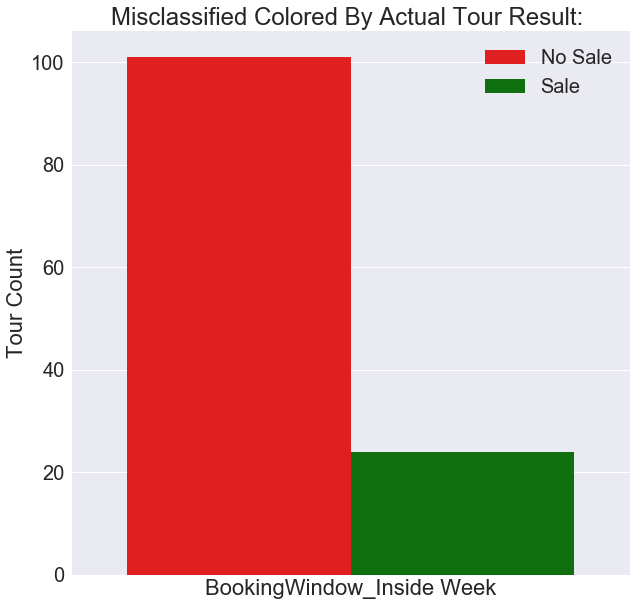

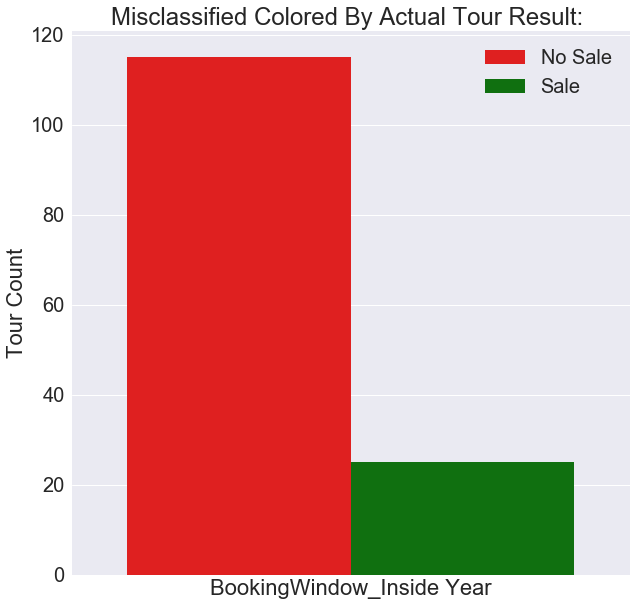

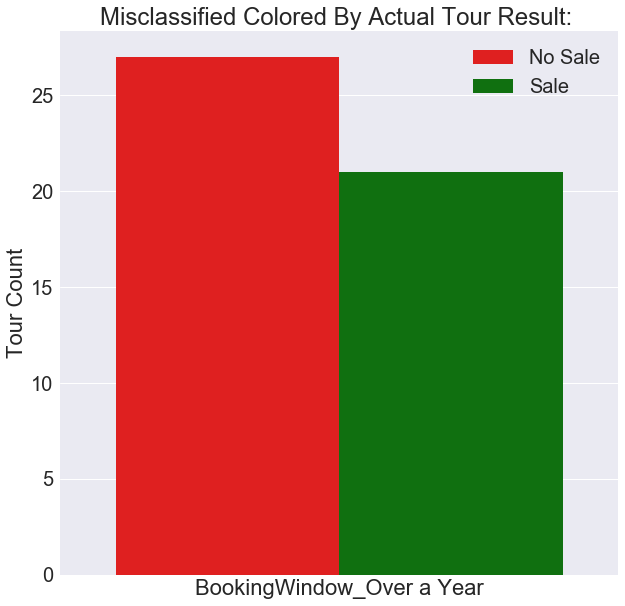

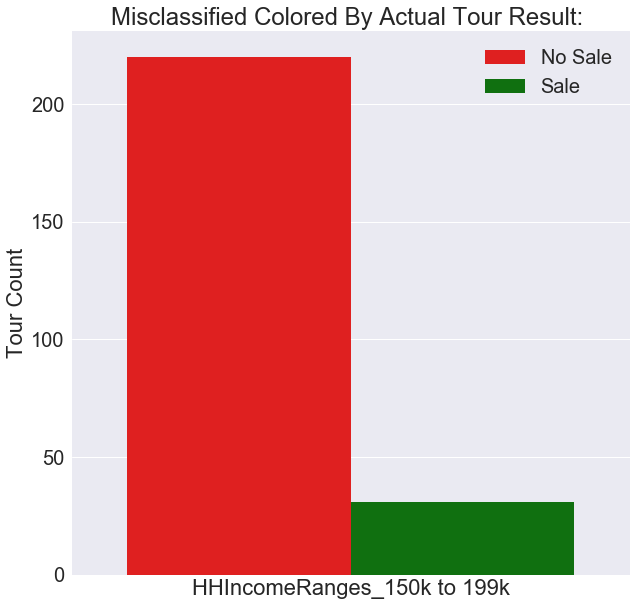

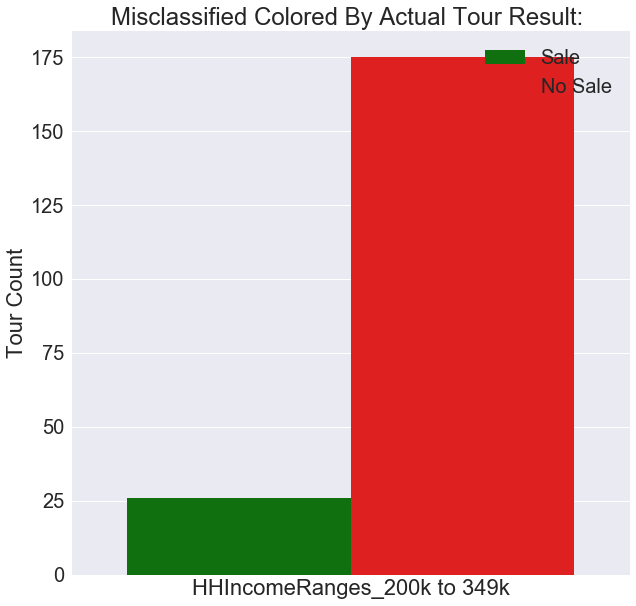

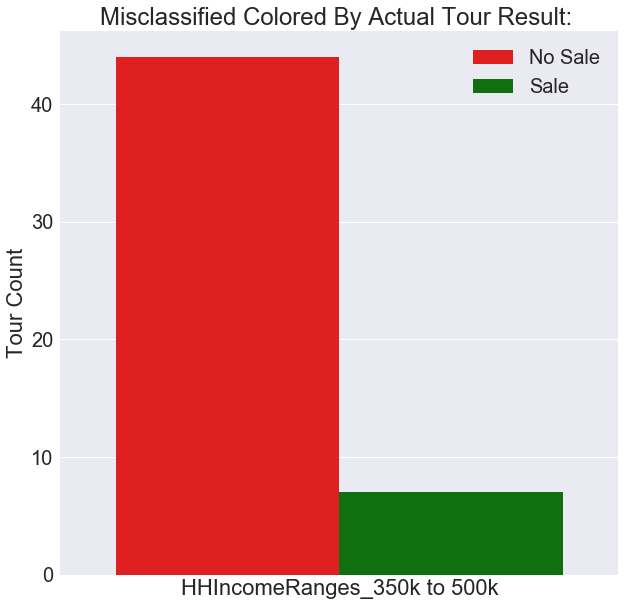

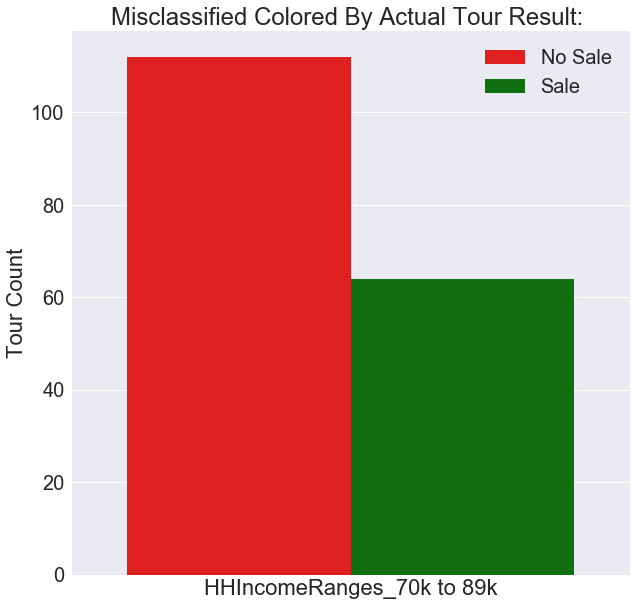

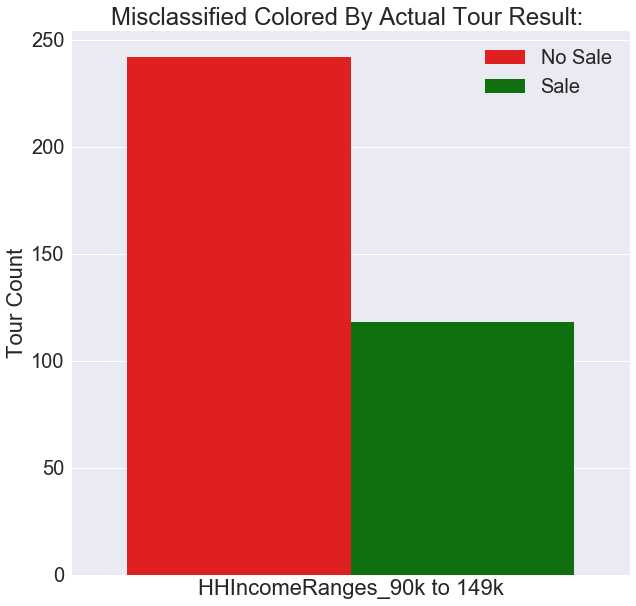

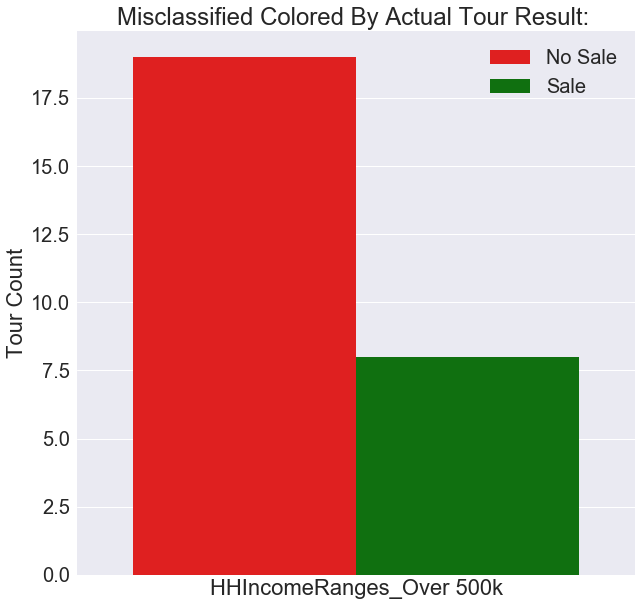

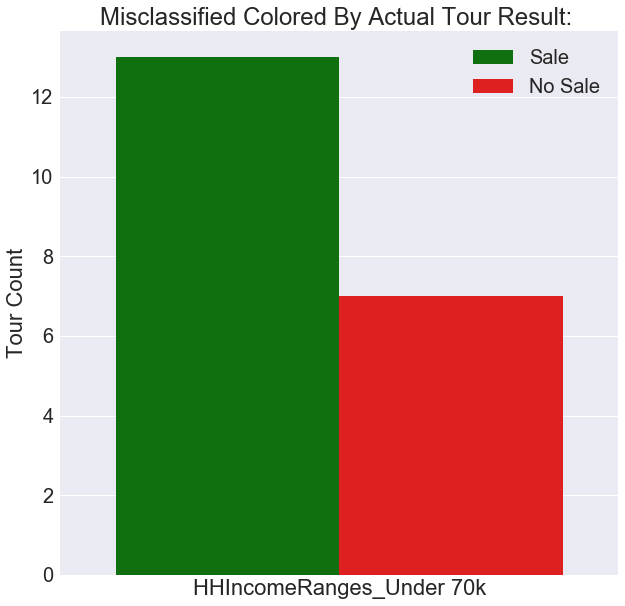

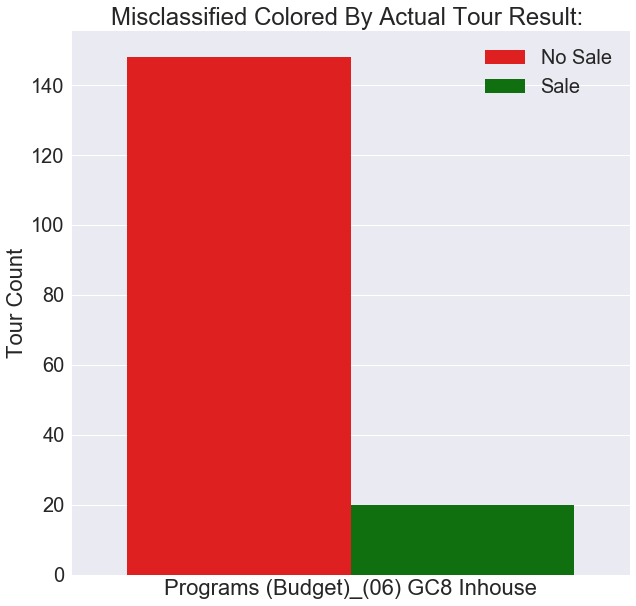

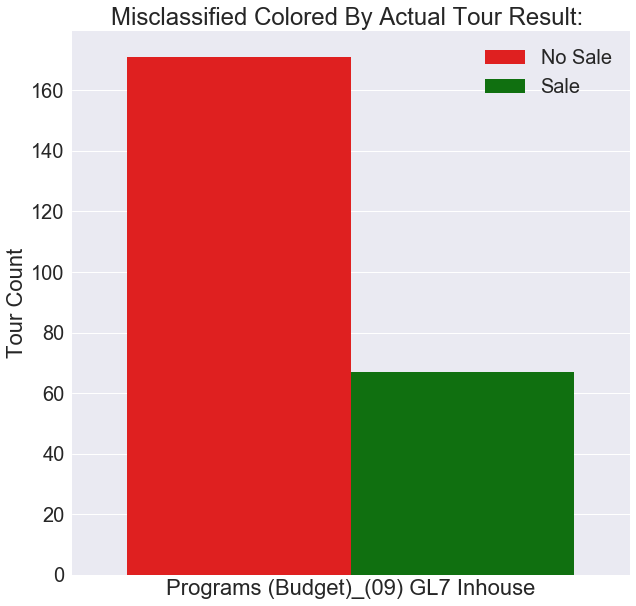

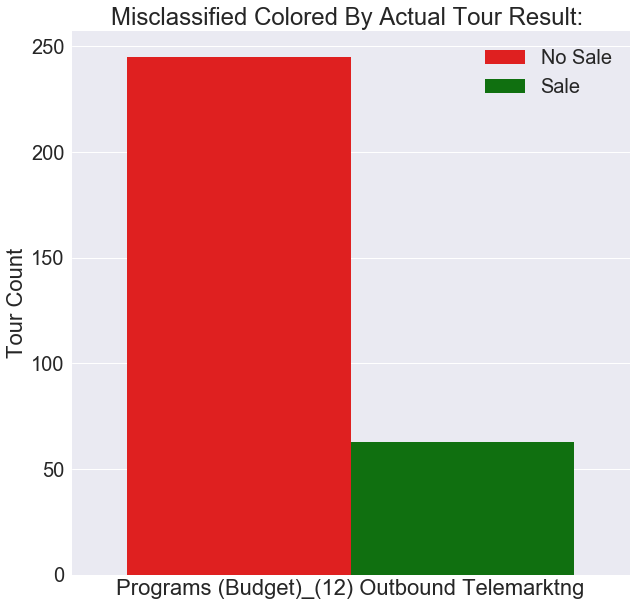

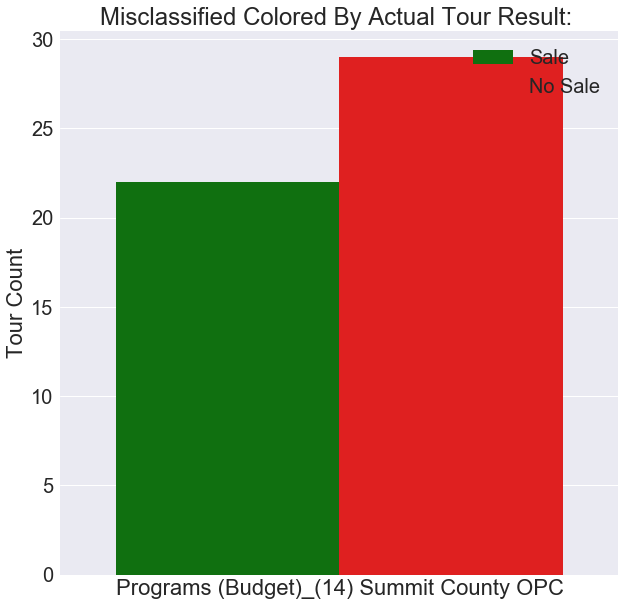

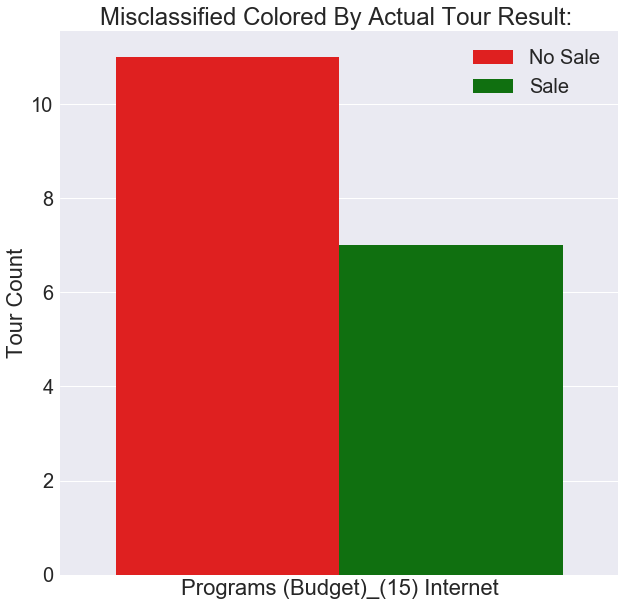

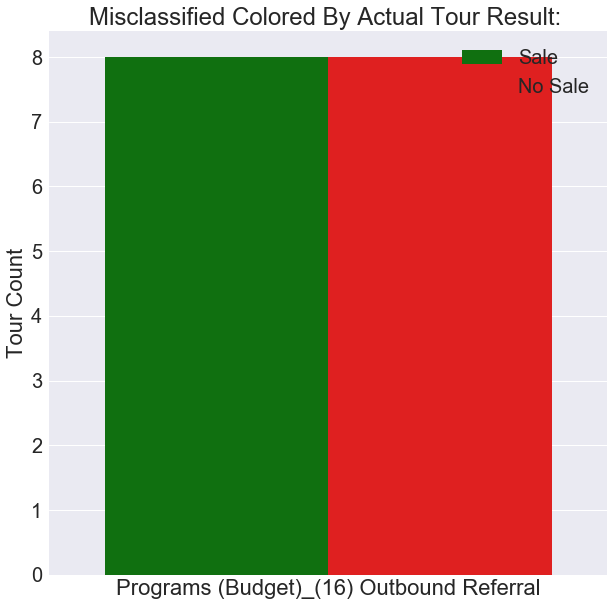

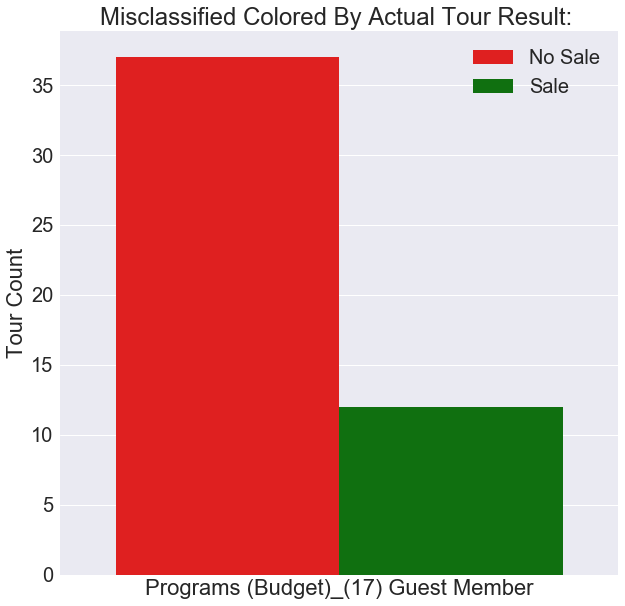

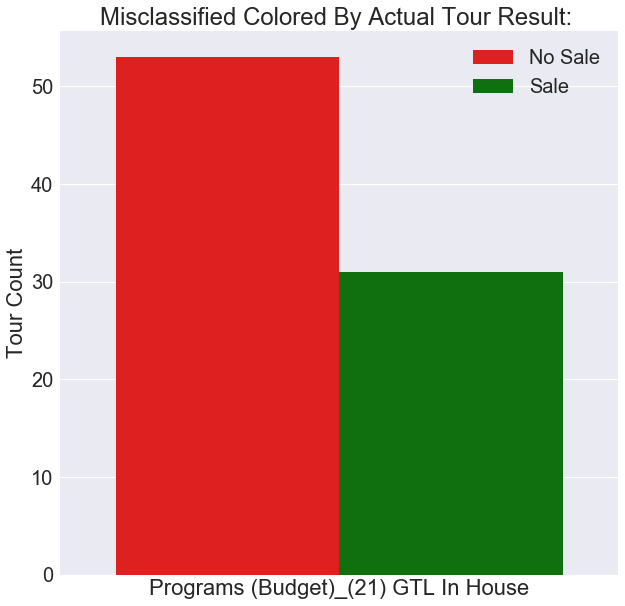

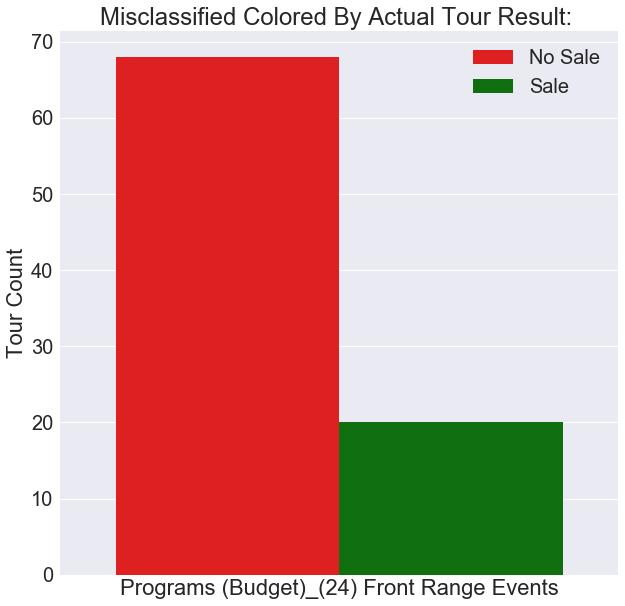

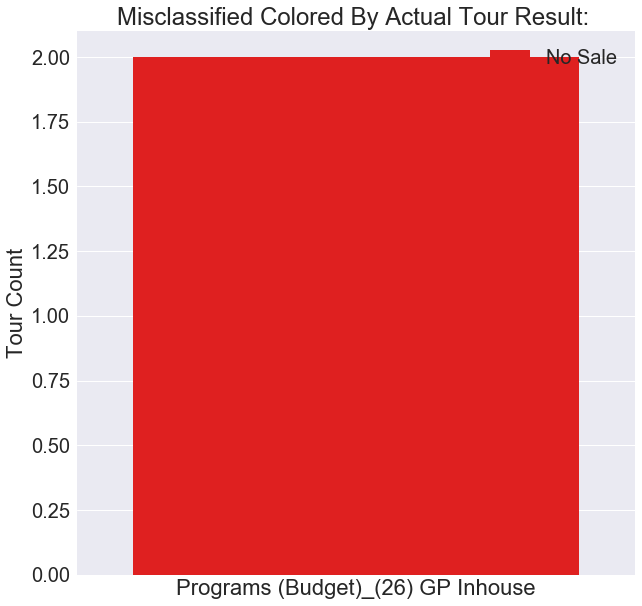

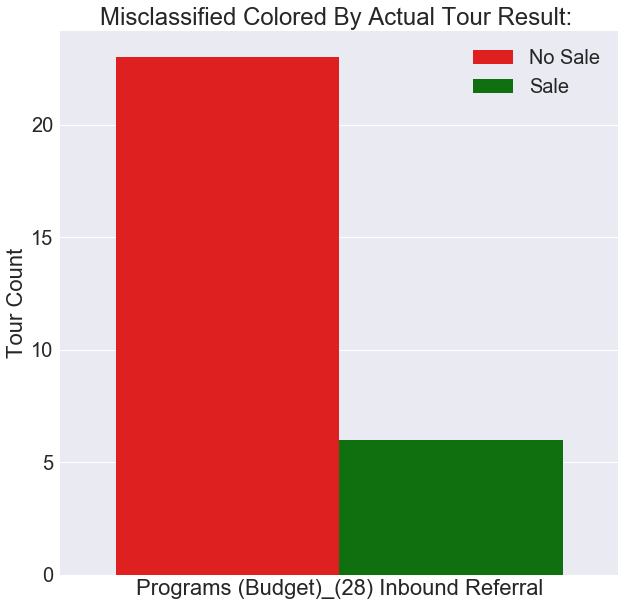

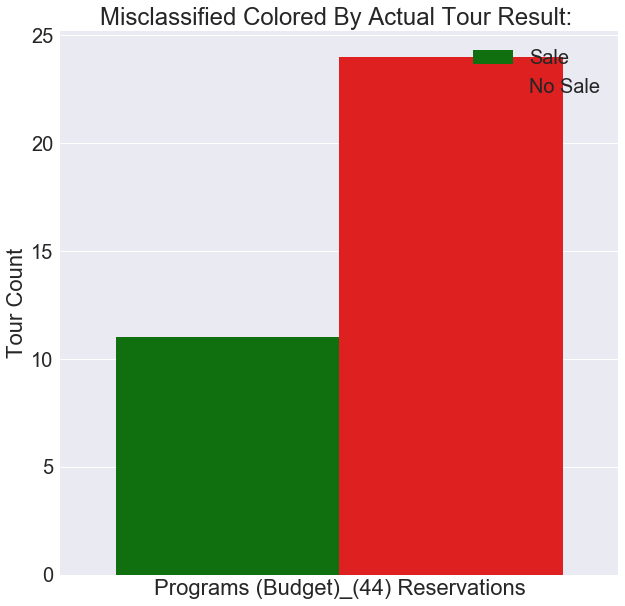

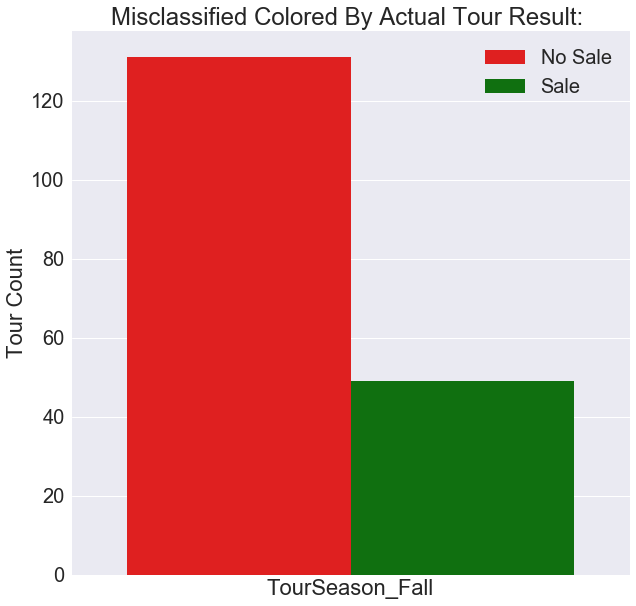

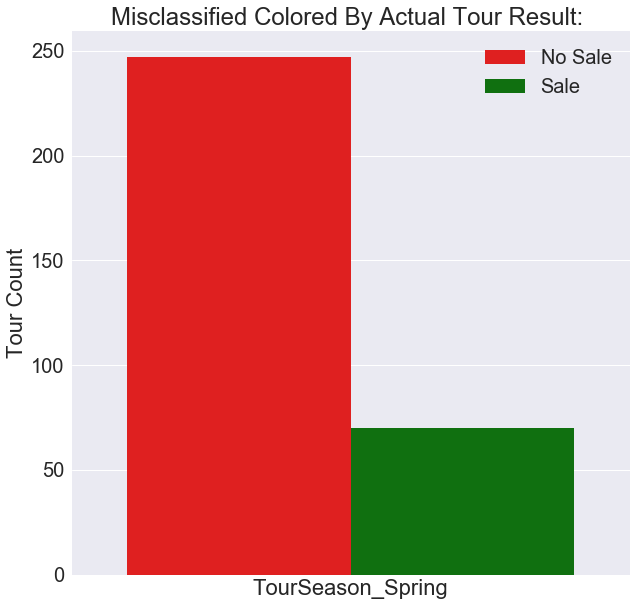

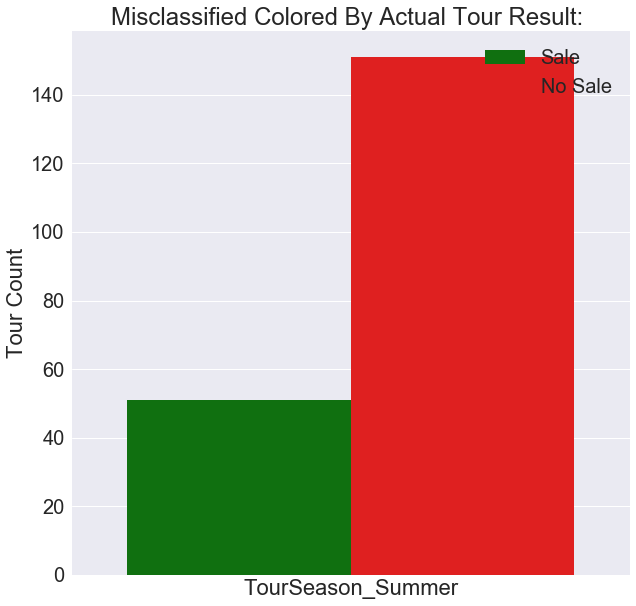

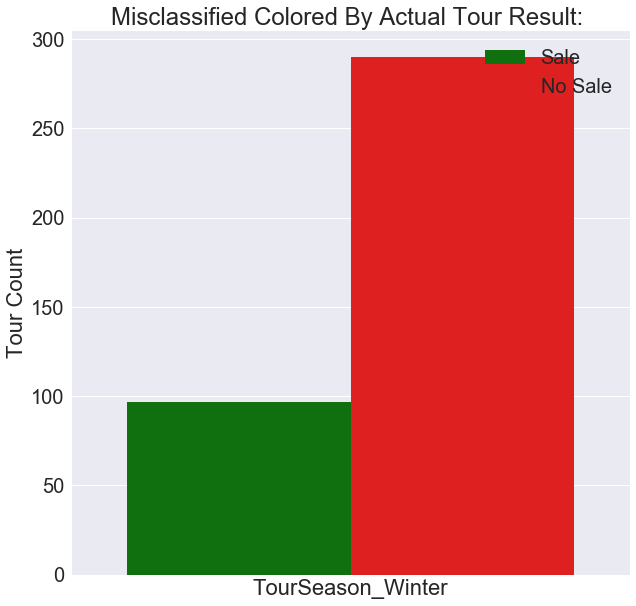

In [11]:
# create countplot of tour count by first gen vs owner misclasifieds
# loop through variable to see misclassified
for i, col in enumerate(x_mis.drop(['prediction',   'actual'], axis = 1).columns):
    plt.title('Misclassified Colored By Actual Tour Result: ')
    if '_' not in col:
        sns.countplot(x= col, hue= 'actual', data = x_mis, palette={'Sale':'Green','No Sale':'Red'})
    else:
        sns.countplot(x= col, hue= 'actual', data = x_mis[x_mis[col]>0], palette={'Sale':'Green','No Sale':'Red'})
        plt.xticks([], [])
    plt.legend(loc = 'upper right')
    plt.ylabel('Tour Count')
    plt.show()

In [12]:
print('Total Misclassified: ',str(len(x_mis['relationStatus'])))
print('Total Buyers Misclassified: ',str(len(x_mis[x_mis['actual']=='Sale'])))
print('Percent Misclassified: ',str(len(x_mis['relationStatus'])/len(X_test['relationStatus'])*100))
print('Percent Buyers Misclassified: ',str(len(x_mis[x_mis['actual']=='Sale'])/len(y_test[y_test == 1])*100))

Total Misclassified:  1086
Total Buyers Misclassified:  267
Percent Misclassified:  34.44338725023787
Percent Buyers Misclassified:  47.17314487632509
